In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

In [ ]:
1# Import spotify API package
!pip install spotipy
!pip install urllib3

import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth

# Import additional dataset (has not been used)
# !pip install opendatasets

# import opendatasets as od

# Import python stuff
import requests
import shutil
import numpy as np
import pandas as pd
import os
import os.path as path
from IPython.display import display, Audio
import matplotlib.pyplot as plt
import warnings
import joblib
import yaml
from tqdm import tqdm

# Import models
!pip install catboost

import catboost

#import sklearn
import sklearn as skl

# Import Keras
from tensorflow import keras
from keras import layers
from keras import models

# Import librosa
!pip install ffmpeg-python

import librosa
import librosa.display

In [ ]:
# if not path.isfile('./gdrive/MyDrive/Cuetessa/top-tracks-of-2017/featuresdf.csv'):
#   od.download('https://www.kaggle.com/datasets/nadintamer/top-tracks-of-2017', data_dir='./gdrive/MyDrive/Cuetessa', force=True)
# top100_2017 = pd.read_csv('./gdrive/MyDrive/Cuetessa/top-tracks-of-2017/featuresdf.csv')

with open('/content/gdrive/MyDrive/spotify/spotify.yaml', 'r') as f:
  yaml_file = yaml.load(f, Loader=yaml.loader.SafeLoader)

cid = yaml_file['client_id']
secret = yaml_file['client_secret']
redirect = 'https://example.com'

scope = "playlist-modify-public"

sp = spotipy.Spotify(
        auth_manager=spotipy.SpotifyOAuth(
          client_id=cid,
          client_secret=secret,
          redirect_uri=redirect,
          scope=scope, open_browser=False)
        )



In [ ]:
result = sp.playlist_tracks('6a66cg3HcsjYkisYyQcov6', market='US')

In [ ]:
def save_track_info(track):
  infos = ['id', 'name', 'explicit', 'uri', 'preview_url']
  result = {info: track['track'][info] for info in infos}
  result['artists'] = [artist['name'] for artist in track['track']['artists'] ]
  result['artists'] = ' \\ '.join(result['artists'])
  return result

tracks = [save_track_info(track) for track in result['items'] ]
while result['next']:
  result = sp.next(result)
  tracks.extend([save_track_info(track) for track in result['items'] ])

tracks = pd.DataFrame(tracks)
tracks.head()

,id,name,explicit,uri,preview_url,artists
0,0pqnGHJpmpxLKifKRmU6WP,Believer,False,spotify:track:0pqnGHJpmpxLKifKRmU6WP,https://p.scdn.co/mp3-preview/4b5e66e725d303b0...,Imagine Dragons
1,2YpeDb67231RjR0MgVLzsG,Old Town Road - Remix,False,spotify:track:2YpeDb67231RjR0MgVLzsG,https://p.scdn.co/mp3-preview/b1b4f28e5b4fc679...,Lil Nas X \ Billy Ray Cyrus
2,6b2RcmUt1g9N9mQ3CbjX2Y,How Do You Sleep?,False,spotify:track:6b2RcmUt1g9N9mQ3CbjX2Y,https://p.scdn.co/mp3-preview/15190e5791386e4d...,Sam Smith
3,7qEHsqek33rTcFNT9PFqLf,Someone You Loved,False,spotify:track:7qEHsqek33rTcFNT9PFqLf,https://p.scdn.co/mp3-preview/ae0a42ca5dca210c...,Lewis Capaldi
4,3LlAyCYU26dvFZBDUIMb7a,Demons,False,spotify:track:3LlAyCYU26dvFZBDUIMb7a,https://p.scdn.co/mp3-preview/ff439dff9263b67a...,Imagine Dragons


In [ ]:
batchsize = 100
audio_features = []

for i in range(0, len(tracks.uri.values), batchsize):
  batch = tracks.uri.values[i:i+batchsize]
  audio_features.extend(sp.audio_features(tracks=batch))

drop_cols = ['id', 'uri', 'track_href', 'analysis_url', 'type']
spotify_top = tracks.join( pd.DataFrame(audio_features).drop(drop_cols, axis=1) )
spotify_top.head()

In [ ]:
print('Number of duplicated rows:', spotify_top[spotify_top.duplicated()].shape[0])
display(spotify_top[spotify_top.duplicated()][['name', 'artists']].head())

print('Dropping duplicated rows...')
spotify_top = spotify_top[~spotify_top.duplicated()]
print('New size of spotify_top:', spotify_top.shape[0])

In [ ]:
def download_file(url, filename):
    with requests.get(url, stream=True) as r:
      with open(filename, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
    return filename

folder_name = 'mp3_samples'
file_type = 'mp3'
n_mels = 64

if not path.exists('/content/' + folder_name) and not path.exists('/content/gdrive/MyDrive/Cuetessa/audio_data_' + str(n_mels) + '.joblib'):
  print('Audio data not found! Downloading...')
  if not path.exists('/content/' + folder_name):
        print('Folder not found! Creating folder...')
        os.makedirs('/content/' + folder_name)
  for id, preview_url in zip(spotify_top.id.values, spotify_top.preview_url.values):
      filename = '/content/' + folder_name + '/' + id + '.' + file_type
      download_file(preview_url, filename=filename)
  print('All files downloaded!')

else:
  print('Audio data has already been downloaded. Skipping preview downloads...')

In [ ]:
df = spotify_top.reset_index(drop=True).copy()

In [ ]:
df.head()

,id,name,explicit,uri,preview_url,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,filename
0,0pqnGHJpmpxLKifKRmU6WP,Believer,False,spotify:track:0pqnGHJpmpxLKifKRmU6WP,https://p.scdn.co/mp3-preview/4b5e66e725d303b0...,Imagine Dragons,0.776,0.780,10,-4.374,0,0.1280,0.0622,0.00000,0.0810,0.666,124.949,204347,4,/content/mp3_samples/0pqnGHJpmpxLKifKRmU6WP.mp3
1,2YpeDb67231RjR0MgVLzsG,Old Town Road - Remix,False,spotify:track:2YpeDb67231RjR0MgVLzsG,https://p.scdn.co/mp3-preview/b1b4f28e5b4fc679...,Lil Nas X \ Billy Ray Cyrus,0.878,0.619,6,-5.560,1,0.1020,0.0533,0.00000,0.1130,0.639,136.041,157067,4,/content/mp3_samples/2YpeDb67231RjR0MgVLzsG.mp3
2,6b2RcmUt1g9N9mQ3CbjX2Y,How Do You Sleep?,False,spotify:track:6b2RcmUt1g9N9mQ3CbjX2Y,https://p.scdn.co/mp3-preview/15190e5791386e4d...,Sam Smith,0.477,0.682,1,-4.931,0,0.0925,0.1530,0.00000,0.0763,0.345,110.567,202205,5,/content/mp3_samples/6b2RcmUt1g9N9mQ3CbjX2Y.mp3
3,7qEHsqek33rTcFNT9PFqLf,Someone You Loved,False,spotify:track:7qEHsqek33rTcFNT9PFqLf,https://p.scdn.co/mp3-preview/ae0a42ca5dca210c...,Lewis Capaldi,0.501,0.405,1,-5.679,1,0.0319,0.7510,0.00000,0.1050,0.446,109.891,182161,4,/content/mp3_samples/7qEHsqek33rTcFNT9PFqLf.mp3
4,3LlAyCYU26dvFZBDUIMb7a,Demons,False,spotify:track:3LlAyCYU26dvFZBDUIMb7a,https://p.scdn.co/mp3-preview/ff439dff9263b67a...,Imagine Dragons,0.505,0.710,3,-3.015,1,0.0321,0.1900,0.00025,0.3290,0.428,89.938,175200,4,/content/mp3_samples/3LlAyCYU26dvFZBDUIMb7a.mp3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631 entries, 0 to 1630
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1631 non-null   object 
 1   name              1631 non-null   object 
 2   explicit          1631 non-null   bool   
 3   uri               1631 non-null   object 
 4   preview_url       1631 non-null   object 
 5   artists           1631 non-null   object 
 6   danceability      1631 non-null   float64
 7   energy            1631 non-null   float64
 8   key               1631 non-null   int64  
 9   loudness          1631 non-null   float64
 10  mode              1631 non-null   int64  
 11  speechiness       1631 non-null   float64
 12  acousticness      1631 non-null   float64
 13  instrumentalness  1631 non-null   float64
 14  liveness          1631 non-null   float64
 15  valence           1631 non-null   float64
 16  tempo             1631 non-null   float64


In [ ]:
def read_audio_data(f, n_mels):
  y, sr = librosa.load(f, duration=30)
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  rmse = librosa.feature.rms(y=y)[0]
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
  zcr = librosa.feature.zero_crossing_rate(y, pad=False)
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
  result = {
      'chroma': chroma_stft,
      'rmse': rmse,
      'spec_cent': spec_cent,
      'spec_bw': spec_bw,
      'rolloff': rolloff,
      'zcr': zcr,
      'melspectrogram': melspectrogram
  }
  return result

spotify_top['filename'] = '/content/' + folder_name + '/' + spotify_top['id'] + '.mp3'


warnings.filterwarnings('ignore', category=UserWarning, module='librosa')
if not path.exists('/content/gdrive/MyDrive/Cuetessa/audio_data_' + str(n_mels) + '.joblib'):
  audio_data = []
  for i in tqdm(range(len(spotify_top.filename.values))):
    f = spotify_top.filename.values[i]
    audio_data.append(read_audio_data(f, n_mels=n_mels))
  print('Audio data succesfully processed!')
  joblib.dump(audio_data, '/content/gdrive/MyDrive/Cuetessa/audio_data_' + str(n_mels) + '.joblib')
else:
  audio_data = joblib.load('/content/gdrive/MyDrive/Cuetessa/audio_data_' + str(n_mels) + '.joblib')
  print('Audio data succesfully loaded!')

In [ ]:
X = pd.DataFrame(audio_data)
Y = spotify_top['valence']

del audio_data

In [ ]:
for i in X.columns:
  print(i, 'is shape', X[i][0].shape)

print('Correcting shape of observations rmse...')

X['rmse'] = X['rmse'].apply(lambda x: np.array([x]))

print('rmse is shape', X['rmse'][0].shape)

chroma is shape (12, 1292)
rmse is shape (1292,)
spec_cent is shape (1, 1292)
spec_bw is shape (1, 1292)
rolloff is shape (1, 1292)
zcr is shape (1, 1292)
melspectrogram is shape (64, 1292)
Correcting shape of observations rmse...
rmse is shape (1, 1292)


In [ ]:
shape_dict = {}
for i in X.columns:
  shape_dict[i] = []
  for j in X[i]:
    shape_dict[i].append(j.shape[1])

preview_sizes = pd.Series(shape_dict['chroma']).value_counts()
preview_sizes

In [ ]:
for i in preview_sizes[1:].index.values:
  while True:
    try:
      delete_index = shape_dict['chroma'].index(i)
      X.drop(delete_index, inplace=True)
      Y.drop(delete_index, inplace=True)
      df.drop(delete_index, inplace=True)
      shape_dict['chroma'][delete_index] = None
    except:
      break

In [ ]:
shape_dict = {}
for i in X.columns:
  shape_dict[i] = []
  for j in X[i]:
    shape_dict[i].append(j.shape[1])

preview_sizes = pd.Series(shape_dict['chroma']).value_counts()
preview_sizes

In [ ]:
for i in ['X', 'Y', 'df']:
  globals()[i].reset_index(drop=True, inplace=True)
  print('Shape of', i, 'is', globals()[i].shape)

In [ ]:
single_size = [i for i in X.columns if i != 'melspectrogram']
for i in single_size:
  X.loc[:][i] = X[i].apply(lambda x: np.resize(x, (1, preview_sizes.index.values[0])))
X.loc[:]['melspectrogram'] = X['melspectrogram'].apply(lambda x: np.resize(x, (n_mels, preview_sizes.index.values[0])))

In [ ]:
print('At this point, all features from audio data are standardized regarding shapes.')

At this point, all features from audio data are standardized regarding shapes.


In [ ]:
n_samples = 1
samples = df.sample(n_samples, random_state=2023).index

print('Sampled songs are:', list(samples.values), end='\n\n')

for i in samples:
  print(i)
  print('Song name is:', df.iloc[i]['name'])
  print('Song artist is:', df.iloc[i]['artists'])
  print('Song valence is:', df.iloc[i]['valence'], end='\n\n')

Sampled songs are: [564]

564
Song name is: Only
Song artist is: Imagine Dragons
Song valence is: 0.424



In [ ]:
X.columns

Index(['chroma', 'rmse', 'spec_cent', 'spec_bw', 'rolloff', 'zcr',
       'melspectrogram'],
      dtype='object')

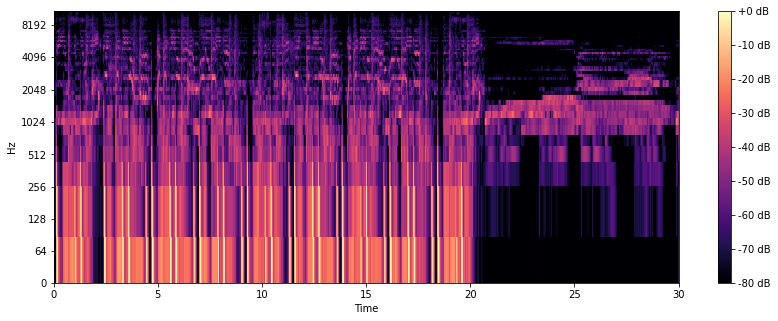

In [ ]:
for i in samples.values:
  plt.figure(figsize=(14,5))
  melspect = X.loc[i]['melspectrogram']
  DB = librosa.amplitude_to_db(melspect, ref=np.max)
  librosa.display.specshow(DB, x_axis='time', y_axis='log');
  plt.colorbar(format='%+2.0f dB');

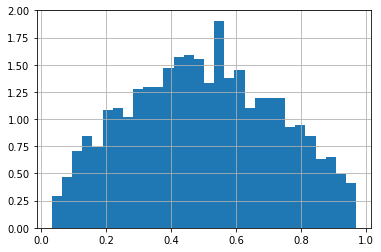

In [ ]:
Y.hist(density=True, bins=30)
plt.show()

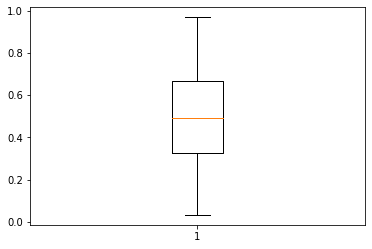

In [ ]:
plt.boxplot(Y)
plt.show()

In [ ]:
X_alt = pd.DataFrame(np.zeros(X.shape[0]), columns=['chroma_mean'])

for i in single_size:
  X_alt[i + '_mean'] = X[i].apply(lambda x: np.mean(x[0]))
  X_alt[i + '_var'] = X[i].apply(lambda x: np.var(x[0]))
  X_alt[i + '_min'] = X[i].apply(lambda x: min(x[0]))
  X_alt[i + '_max'] = X[i].apply(lambda x: max(x[0]))

In [ ]:
X_alt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1628 entries, 0 to 1627
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   chroma_mean     1628 non-null   float32
 1   chroma_var      1628 non-null   float32
 2   chroma_min      1628 non-null   float32
 3   chroma_max      1628 non-null   float32
 4   rmse_mean       1628 non-null   float32
 5   rmse_var        1628 non-null   float32
 6   rmse_min        1628 non-null   float32
 7   rmse_max        1628 non-null   float32
 8   spec_cent_mean  1628 non-null   float64
 9   spec_cent_var   1628 non-null   float64
 10  spec_cent_min   1628 non-null   float64
 11  spec_cent_max   1628 non-null   float64
 12  spec_bw_mean    1628 non-null   float64
 13  spec_bw_var     1628 non-null   float64
 14  spec_bw_min     1628 non-null   float64
 15  spec_bw_max     1628 non-null   float64
 16  rolloff_mean    1628 non-null   float64
 17  rolloff_var     1628 non-null   f

In [ ]:
X_train = X.iloc[df.sample(frac=0.8).index]
X_alt_train = X_alt.iloc[X_train.index]
Y_train = Y.iloc[X_train.index]

X_test = X.iloc[[i for i in df.index if i not in X_train.index]]
X_alt_test = X_alt.iloc[X_test.index]
Y_test = Y.iloc[X_test.index]

X_train_mel = np.dstack(X_train['melspectrogram'])
X_test_mel = np.dstack(X_test['melspectrogram'])

X_train_mel = np.transpose(X_train_mel, (2, 0, 1))
X_test_mel = np.transpose(X_test_mel, (2, 0, 1))

In [ ]:
display(X_train.shape)
display(X_alt_train.shape)
display(Y_train.shape)

display(X_test.shape)
display(X_alt_test.shape)
display(Y_test.shape)

In [ ]:
cat = catboost.CatBoostRegressor(random_state=1995, verbose=False)
cat_dict = {
    'depth': [3, 5],
    'learning_rate': [0.01, 0.03, 0.05],
    'iterations': [500, 1000]
}

In [ ]:
results = cat.grid_search(cat_dict, X=X_alt_train, y=Y_train, cv=3, verbose=False)

In [ ]:
pd.DataFrame(results)

,params,cv_results
depth,5.00,NaN
iterations,1000.00,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
learning_rate,0.03,NaN
test-RMSE-mean,NaN,"[0.5324648029683282, 0.520421042621819, 0.5084..."
test-RMSE-std,NaN,"[0.0050436748082074495, 0.0051458570579528086,..."
train-RMSE-mean,NaN,"[0.5323960918569846, 0.5202270065429969, 0.508..."
train-RMSE-std,NaN,"[0.0022049292164513725, 0.0021191722711956284,..."


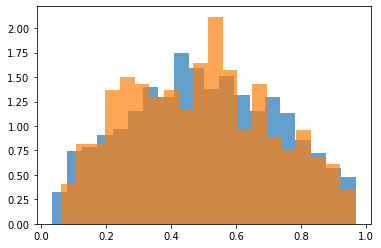

In [ ]:
plt.hist(Y_train, bins=20, density=True, alpha=0.7)
plt.hist(Y_test, bins=20, density=True, alpha=0.7)
plt.show()

In [ ]:
prediction = cat.predict(X_alt_test)
print(np.sqrt(skl.metrics.mean_squared_error(prediction, Y_test)))

In [ ]:
input_shape=(n_mels,preview_sizes.index.values[0], 1)
CNNmodel = models.Sequential()
CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Dense(32, activation='relu'))
CNNmodel.add(layers.Dense(1, activation='linear'))

CNNmodel.compile(loss='mean_squared_error', # one may use 'mean_absolute_error' as  mean_squared_error
                 optimizer='adam',
                 metrics=['mean_absolute_error'] # you can add several if needed
                 )

CNNmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 1290, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 645, 32)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 31, 645, 32)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 643, 64)       18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 321, 64)      0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 14, 321, 64)      

In [ ]:
CNNmodel.fit(X_train_mel, Y_train, epochs=150, batch_size=batchsize, verbose=2)

In [ ]:
score = CNNmodel.evaluate(X_test, Y_test, verbose=0)

In [ ]:
joblib.dump(CNNmodel, '/content/gdrive/MyDrive/Cuetessa/CNNmodel2.joblib')

In [ ]:
prediction = CNNmodel.predict(X_test)
print(np.sqrt(skl.metrics.mean_absolute_error(prediction, Y_test)))
print(skl.metrics.r2_score(prediction, Y_test))

11/11 [==============================] - 5s 440ms/step


array([[0.578882  ],
       [0.45341143],
       [0.534594  ],
       [0.5162951 ],
       [0.47802904],
       [0.50198275],
       [0.50947934],
       [0.5128258 ],
       [0.5828963 ],
       [0.48564237],
       [0.7818805 ],
       [0.27907753],
       [0.5162951 ],
       [0.5259607 ],
       [0.5162951 ],
       [0.5162951 ],
       [0.49463043],
       [0.5124551 ],
       [0.47319573],
       [0.45819095],
       [0.44475436],
       [0.61660206],
       [0.5162951 ],
       [0.65806097],
       [0.4211634 ],
       [0.52741957],
       [0.51369494],
       [0.5152396 ],
       [0.5162951 ],
       [0.48953015],
       [0.25887477],
       [0.36411268],
       [0.49032736],
       [0.5188952 ],
       [0.44598395],
       [0.3115015 ],
       [0.4181109 ],
       [0.42753217],
       [0.50833154],
       [0.78323126],
       [0.62381524],
       [0.5162951 ],
       [0.3735687 ],
       [0.5876527 ],
       [0.56606454],
       [0.506699  ],
       [0.43565536],
       [0.390